In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn import grid_search
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split
import xgboost as xgb

from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics


In [2]:
train = pd.read_csv('numerai_training_data.csv')
test = pd.read_csv('numerai_tournament_data.csv')
example = pd.read_csv('example_predictions.csv')

#train = train.iloc[10000:80000]

In [3]:
X = train.drop('target', axis=1)
y = train.target

id_test = test.t_id
df_test = test.drop('t_id', axis=1, inplace = True)


X_fit, X_eval, y_fit, y_eval= train_test_split(
    X, y, test_size=0.10, random_state=1
)

In [23]:
rf = RandomForestClassifier(n_estimators=1000, n_jobs=4, max_depth =7)
rf.fit(X_fit, y_fit)
print 'RandomForestClassifier ', (log_loss(y_eval, rf.predict_proba(X_eval)))

submission = pd.DataFrame({"t_id":id_test, "probability":rf.predict_proba(test)[:,1]})
submission.to_csv("submission_rf_5.csv", index=False)

RandomForestClassifier  0.691367878221


In [24]:
lr = LogisticRegression()

CVscores = cross_validation.cross_val_score(lr, X, y, scoring='log_loss', cv=5)

# search for the regularization parameter
Cs = 10**np.linspace(-4, 4, num=15)
grid = {'C': Cs}
gridsearch = grid_search.GridSearchCV(lr, grid, scoring='log_loss', cv=5)
gridsearch.fit(X, y)
gridscores = [-x.mean_validation_score for x in gridsearch.grid_scores_]

C = Cs[np.argmin(gridscores)]

# refit the model with the new regularization parameter
lrCV = LogisticRegression(C=C)
lrCV.fit(X_fit, y_fit)

# write log to file
logloss_train = log_loss(y_fit, lrCV.predict_proba(X_fit))
logloss_val = log_loss(y_eval, lrCV.predict_proba(X_eval))

print 'logloss_train: ', logloss_train
print 'logloss_val: ', logloss_val

logloss_train:  0.691439680306
logloss_val:  0.691449256838


In [25]:
#n_estimators and early_stopping_rounds should be increased
clf = xgb.XGBClassifier(missing=np.nan, max_depth=3, 
                        n_estimators=1500, learning_rate=0.005, gamma =0.3, min_child_weight = 3,
                        subsample=0.9, colsample_bytree=0.8, seed=2100,objective= 'binary:logistic')
# 'colsample_bytree': 0.8,
#   'gamma': 0.3,
#   'max_depth': 4,
#   'min_child_weight': 3,
#   'subsample': 0.9


# fitting
clf.fit(X_fit, y_fit, early_stopping_rounds=150,  eval_metric="logloss", eval_set=[(X_eval, y_eval)])

# scores
from  sklearn.metrics import log_loss
log_train = log_loss(y_fit, clf.predict_proba(X_fit)[:,1])
log_valid = log_loss(y_eval, clf.predict_proba(X_eval)[:,1])


print('\n-----------------------')
print('  logloss train: %.5f'%log_train)
print('  logloss valid: %.5f'%log_valid)
print('-----------------------')

print('\nModel parameters...')
print(clf.get_params())

#print y_pred
# y_pred= clf.predict_proba(test)[:,1]

# submission = pd.DataFrame({"t_id":id_test, "probability":y_pred})
# submission.to_csv("submission_xgboost.csv", index=False)

Will train until validation_0 error hasn't decreased in 150 rounds.
[0]	validation_0-logloss:0.693143
[1]	validation_0-logloss:0.693119
[2]	validation_0-logloss:0.693123
[3]	validation_0-logloss:0.693103
[4]	validation_0-logloss:0.693102
[5]	validation_0-logloss:0.693087
[6]	validation_0-logloss:0.693077
[7]	validation_0-logloss:0.693072
[8]	validation_0-logloss:0.693058
[9]	validation_0-logloss:0.693051
[10]	validation_0-logloss:0.693039
[11]	validation_0-logloss:0.693033
[12]	validation_0-logloss:0.693023
[13]	validation_0-logloss:0.693014
[14]	validation_0-logloss:0.693004
[15]	validation_0-logloss:0.692996
[16]	validation_0-logloss:0.692993
[17]	validation_0-logloss:0.692982
[18]	validation_0-logloss:0.692973
[19]	validation_0-logloss:0.692961
[20]	validation_0-logloss:0.692954
[21]	validation_0-logloss:0.692946
[22]	validation_0-logloss:0.692939
[23]	validation_0-logloss:0.692928
[24]	validation_0-logloss:0.692921
[25]	validation_0-logloss:0.692911
[26]	validation_0-logloss:0.6929


-----------------------
  logloss train: 0.68744
  logloss valid: 0.69121
-----------------------

Model parameters...
{'reg_alpha': 0, 'colsample_bytree': 0.8, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.005, 'missing': None, 'max_delta_step': 0, 'nthread': -1, 'base_score': 0.5, 'n_estimators': 1500, 'subsample': 0.9, 'reg_lambda': 1, 'seed': 2100, 'min_child_weight': 3, 'objective': 'binary:logistic', 'max_depth': 3, 'gamma': 0.3}


In [5]:
y_pred= clf.predict_proba(test)[:,1]

submission = pd.DataFrame({"t_id":id_test, "probability":y_pred})
submission.to_csv("submission_xgboost.csv", index=False)

In [8]:
print X_fit.values.shape , y_fit.shape, X_eval.shape, y_eval.shape

(86688, 21) (86688,) (9632, 21) (9632,)


In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical


nn = Sequential()
nn.add(Dense(250, input_dim=21, init='uniform'))
nn.add(Dropout(0.4))
nn.add(Activation('sigmoid'))
nn.add(Dense(2, init='uniform'))
nn.add(Activation('softmax'))

opt = Adam(lr=1e-3)
nn.compile(loss='sparse_categorical_crossentropy', optimizer=opt)
#X_fit, y_fit, early_stopping_rounds=150,  eval_metric="logloss", eval_set=[(X_eval, y_eval)
hist = nn.fit(X_fit.values, y_fit.values, nb_epoch=125, verbose=0,validation_data=(X_eval.values, y_eval.values))



In [20]:
y_pred= nn.predict_proba(test.values, verbose=0)[:,1]

submission = pd.DataFrame({"t_id":id_test, "probability":y_pred})
submission.to_csv("submission_NN.csv", index=False)

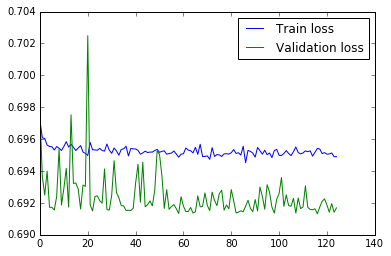

In [21]:
%matplotlib inline

plt.plot(hist.history['loss'][0:])
plt.plot(hist.history['val_loss'][0:])
plt.legend(['Train loss', 'Validation loss'])

In [50]:
clf1_p = rf.predict_proba(X_eval)[:,1]

#Logreg
clf7_p = lrCV.predict_proba(X_eval)[:,1]

#xgb
clf8_p = clf.predict_proba(X_eval)[:,1]

# #NN
clf3_p = nn.predict_proba(X_eval.values, verbose = 0)[:,1]


In [51]:
classifiers = [clf1_p, 
               clf8_p, 
               clf3_p,                
               clf7_p]

predictions = pd.DataFrame(classifiers[0:2]).T

for classif in classifiers:
    print(log_loss(y_eval, classif))

0.691367878221
0.691205202806
0.691689995766
0.691449256838


In [52]:
print(np.corrcoef(classifiers))


[[ 1.          0.93818692  0.88003664  0.85373216]
 [ 0.93818692  1.          0.85944264  0.84256706]
 [ 0.88003664  0.85944264  1.          0.98117145]
 [ 0.85373216  0.84256706  0.98117145  1.        ]]


In [53]:
Ps = np.array(classifiers).T
def ensemble_logloss(w):
    return log_loss(y_eval, (Ps*w).sum(1).T/np.sum(w))

In [54]:
ensemble_logloss(np.ones(len(classifiers)))

0.69127890242990808

In [55]:
def ensemble_roc_auc(w):
    return roc_auc_score(y_eval, (Ps*w).sum(1).T/np.sum(w))

In [56]:
ensemble_roc_auc(np.ones(len(classifiers)))

0.5348664624138677

In [57]:
from scipy.optimize import minimize

opt = minimize(ensemble_logloss, x0=np.ones(len(classifiers)))
print("Function result:", opt.fun)
print("Array:", opt.x)

('Function result:', 0.6911392619336544)
('Array:', array([-0.58555103,  3.6020983 , -1.62525096,  2.6093859 ]))


In [58]:
w = opt.x/opt.x.sum()
w

array([-0.1463628 ,  0.90037102, -0.40624346,  0.65223524])

In [59]:
ensebmle_prob_validation = np.zeros(len(clf1_p))
for i in range(len(classifiers)):
    ensebmle_prob_validation += np.array(classifiers[i]) * w[i]

In [60]:
print log_loss(y_eval, ensebmle_prob_validation), roc_auc_score(y_eval, ensebmle_prob_validation)


0.691139261991 0.53506998657


In [38]:
def optimal(values):
    optimal_classifiers = []
    for i in range(len(values)):
        if values[i] > 0:
            print("Classifier", i+1, "is good")
            optimal_classifiers.append(classifiers[i])
    return optimal_classifiers

In [39]:
def full_negative_elimination(weights):
    global classifiers, Ps
    while sum(weights<0) > 0:
        opt = minimize(ensemble_logloss, x0=np.ones(len(classifiers)))
        print("Function result:", opt.fun)
        classifiers = optimal(opt.x)
        Ps = np.array(classifiers).T
        weights = opt.x/opt.x.sum()
        print("Current weights:", weights)
        print('=======')
    return weights

In [40]:
w = full_negative_elimination(w)


('Function result:', 0.6911392619336544)
('Classifier', 2, 'is good')
('Classifier', 4, 'is good')
('Current weights:', array([-0.1463628 ,  0.90037102, -0.40624346,  0.65223524]))
('Function result:', 0.6911713540305157)
('Classifier', 1, 'is good')
('Classifier', 2, 'is good')
('Current weights:', array([ 0.74141642,  0.25858358]))


In [61]:
dtest = xgb.DMatrix(test)
p1 = rf.predict_proba(test)[:,1]

#Logreg
p7 = lrCV.predict_proba(test)[:,1]

#xgb
p8 = clf.predict_proba(test)[:,1]

p3 = nn.predict_proba(test.values, verbose = 0)[:,1]

test_predictions = [p1, p7, p8, p3]

In [62]:
ensebmle_prob_test = np.zeros(len(p1))
for i in range(len(test_predictions)):
    ensebmle_prob_test += np.array(test_predictions[i]) * w[i]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f47b80631d0>]], dtype=object)

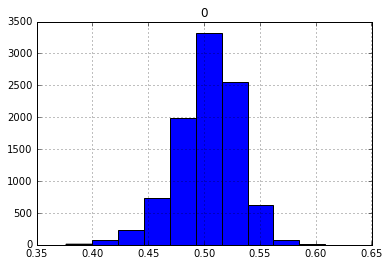

In [63]:
pd.DataFrame(ensebmle_prob_validation).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f47be26a450>]], dtype=object)

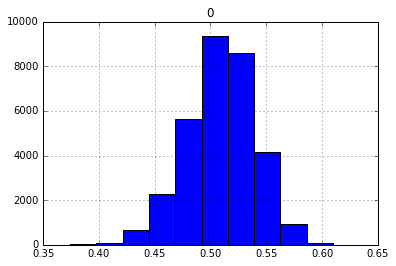

In [64]:
pd.DataFrame(ensebmle_prob_test).hist()

In [65]:
submission = pd.DataFrame({"t_id":id_test, "probability":ensebmle_prob_test})
submission.to_csv("submission_ansemble.csv", index=False)